# Trainable convolutions as density transformations 

In [1]:
import itertools
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar
import tqdm
import pandas as pd
import numpy as np

import torchlft.distributions
import torchlft.metrics

import convnet_phi4.plot

%load_ext lab_black

PI = math.pi

torch.set_printoptions(precision=3, sci_mode=False, threshold=4000)

In [2]:
class ConvLayer(torch.nn.Module):
    def __init__(self, init_kernel: torch.Tensor):
        super().__init__()
        assert init_kernel.shape[-1] == init_kernel.shape[-2]

        self.kernel_size = init_kernel.shape[1]
        self.kernel_radius = self.kernel_size // 2

        self.kernel = torch.nn.Parameter(init_kernel)

    def kernel_as_matrix(self, lattice_size: int):
        kernel_padded_rolled = torch.nn.functional.pad(
            self.kernel,
            (
                0,
                lattice_size - self.kernel_size,
                0,
                lattice_size - self.kernel_size,
            ),
            mode="constant",
            value=0,
        ).roll((-self.kernel_radius, -self.kernel_radius), (0, 1))
        return torch.stack(
            [
                kernel_padded_rolled.roll((x1, x2), dims=(0, 1)).flatten()
                for x1, x2 in itertools.product(
                    range(lattice_size), range(lattice_size)
                )
            ],
            dim=0,
        )

    def conv2d_forward(self, phi: torch.Tensor):
        assert phi.dim() == 3
        assert phi.shape[1] == phi.shape[2]
        lattice_size = phi.shape[1]

        kernel = self.kernel.view(1, 1, self.kernel_size, self.kernel_size)
        phi = torch.nn.functional.pad(
            phi.unsqueeze(dim=1),  # (n_batch, n_channels=1, width, height)
            pad=(self.kernel_radius,) * 4,
            mode="circular",
        )
        phi = torch.nn.functional.conv2d(phi, kernel).squeeze(dim=1)

        return phi

    def matmul_forward(self, phi: torch.Tensor):
        assert phi.dim() == 3
        assert phi.shape[1] == phi.shape[2]
        lattice_size = phi.shape[1]

        phi = phi.flatten(start_dim=1)  # (n_batch, L * L)
        phi = torch.mm(
            phi, self.kernel_as_matrix(lattice_size).T
        )  # batch dimension = matrix rows
        phi = phi.view(-1, lattice_size, lattice_size)

        return phi

    def forward(self, phi: torch.Tensor, log_prob: torch.Tensor):
        assert phi.dim() == 3
        assert phi.shape[1] == phi.shape[2]
        assert log_prob.dim() == 1
        assert log_prob.shape[0] == phi.shape[0]
        lattice_size = phi.shape[1]

        phi = self.conv2d_forward(phi)
        log_det_jacob = torch.slogdet(self.kernel_as_matrix(lattice_size)).logabsdet
        log_prob.sub_(log_det_jacob)

        return phi, log_prob

    @torch.no_grad()
    def visualise(self):
        fig, ax = plt.subplots()
        ax.set_title("Convolution kernel")
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        im = ax.imshow(self.kernel)
        fig.colorbar(im)

        return fig


_kernel = torch.Tensor(
    [
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0],
    ]
)
_layer = ConvLayer(init_kernel=_kernel)
_phi = torch.empty(10, 6, 6).normal_()
_conv2d_out = _layer.conv2d_forward(_phi)
_matmul_out = _layer.matmul_forward(_phi)
assert torch.allclose(_conv2d_out, _matmul_out, atol=1e-6)

In [3]:
x = torch.rand(6, 6)
x.tril_()
print(x)
x.add_(x.tril(-1).T)

tensor([[0.770, 0.000, 0.000, 0.000, 0.000, 0.000],
        [0.044, 0.281, 0.000, 0.000, 0.000, 0.000],
        [0.613, 0.839, 0.042, 0.000, 0.000, 0.000],
        [0.076, 0.353, 0.556, 0.236, 0.000, 0.000],
        [0.488, 0.602, 0.740, 0.872, 0.789, 0.000],
        [0.711, 0.149, 0.300, 0.413, 0.864, 0.804]])


tensor([[0.770, 0.044, 0.613, 0.076, 0.488, 0.711],
        [0.044, 0.281, 0.839, 0.353, 0.602, 0.149],
        [0.613, 0.839, 0.042, 0.556, 0.740, 0.300],
        [0.076, 0.353, 0.556, 0.236, 0.872, 0.413],
        [0.488, 0.602, 0.740, 0.872, 0.789, 0.864],
        [0.711, 0.149, 0.300, 0.413, 0.864, 0.804]])

In [36]:
class RotationInvariantConvLayer(torch.nn.Module):
    def __init__(self, init_kernel: torch.Tensor):
        super().__init__()
        assert init_kernel.shape[0] == init_kernel.shape[1]
        assert torch.allclose(
            init_kernel.triu(diagonal=1), torch.zeros_like(init_kernel)
        )

        self.register_buffer("_mask", torch.ones_like(init_kernel).tril().bool())

        self._kernel = torch.nn.Parameter(init_kernel[self._mask])

        self.kernel_radius = init_kernel.shape[0] - 1
        self.kernel_size = self.kernel_radius * 2 + 1

    @property
    def kernel(self) -> torch.Tensor:
        """Returns square kernel to input into conv2d"""
        lower_right = torch.zeros(
            self.kernel_radius + 1, self.kernel_radius + 1
        ).type_as(self._kernel)
        lower_right.masked_scatter_(mask=self._mask, source=self._kernel)
        lower_right.add_(lower_right.tril(-1).T)

        kernel = torch.zeros(self.kernel_size, self.kernel_size).type_as(self._kernel)
        kernel[self.kernel_radius :, self.kernel_radius :] = lower_right

        vline = torch.ones(self.kernel_size, self.kernel_size).type_as(self._kernel)
        hline = vline.clone()
        vline[:, self.kernel_radius] = 0
        hline[self.kernel_radius, :] = 0

        kernel.add_(kernel.flip(0).mul(hline))
        kernel.add_(kernel.flip(1).mul(vline))

        return kernel

    def kernel_as_matrix(self, lattice_size: int):
        kernel_padded_rolled = torch.nn.functional.pad(
            self.kernel,
            (
                0,
                lattice_size - self.kernel_size,
                0,
                lattice_size - self.kernel_size,
            ),
            mode="constant",
            value=0,
        ).roll((-self.kernel_radius, -self.kernel_radius), (0, 1))
        return torch.stack(
            [
                kernel_padded_rolled.roll((x1, x2), dims=(0, 1)).flatten()
                for x1, x2 in itertools.product(
                    range(lattice_size), range(lattice_size)
                )
            ],
            dim=0,
        )

    def conv2d_forward(self, phi: torch.Tensor):
        assert phi.dim() == 3
        assert phi.shape[1] == phi.shape[2]
        lattice_size = phi.shape[1]

        kernel = self.kernel.view(1, 1, self.kernel_size, self.kernel_size)
        phi = torch.nn.functional.pad(
            phi.unsqueeze(dim=1),  # (n_batch, n_channels=1, width, height)
            pad=(self.kernel_radius,) * 4,
            mode="circular",
        )
        phi = torch.nn.functional.conv2d(phi, kernel).squeeze(dim=1)

        return phi

    def matmul_forward(self, phi: torch.Tensor):
        assert phi.dim() == 3
        assert phi.shape[1] == phi.shape[2]
        lattice_size = phi.shape[1]

        phi = phi.flatten(start_dim=1)  # (n_batch, L * L)
        phi = torch.mm(
            phi, self.kernel_as_matrix(lattice_size).T
        )  # batch dimension = matrix rows
        phi = phi.view(-1, lattice_size, lattice_size)

        return phi

    def forward(self, phi: torch.Tensor, log_prob: torch.Tensor):
        assert phi.dim() == 3
        assert phi.shape[1] == phi.shape[2]
        assert log_prob.dim() == 1
        assert log_prob.shape[0] == phi.shape[0]
        lattice_size = phi.shape[1]

        phi = self.conv2d_forward(phi)
        log_det_jacob = torch.slogdet(self.kernel_as_matrix(lattice_size)).logabsdet
        log_prob.sub_(log_det_jacob)

        return phi, log_prob

    @torch.no_grad()
    def visualise(self):
        fig, ax = plt.subplots()
        ax.set_title("Convolution kernel")
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        im = ax.imshow(self.kernel)
        fig.colorbar(im)

        return fig


_kernel = torch.Tensor(
    [
        [1, 0, 0],
        [2, 4, 0],
        [3, 5, 6],
    ]
)
_layer = RotationInvariantConvLayer(init_kernel=_kernel)
_phi = torch.empty(10, 6, 6).normal_()
assert torch.allclose(_kernel, _layer.kernel[2:, 2:].tril())

_conv2d_out = _layer.conv2d_forward(_phi)
_matmul_out = _layer.matmul_forward(_phi)
assert torch.allclose(_conv2d_out, _matmul_out, atol=1e-6)

In [5]:
class Model(pl.LightningModule):
    def __init__(self, layers, target, batch_size, lattice_size):
        super().__init__()

        self.layers = torch.nn.ModuleList(layers)
        self.target = target

        self.batch_size = batch_size
        self.lattice_size = lattice_size

        self.gauss = torch.distributions.Normal(
            loc=torch.zeros(self.lattice_size, self.lattice_size),
            scale=torch.ones(self.lattice_size, self.lattice_size),
        )

    def forward(self, batch):
        phi, log_prob = batch
        for layer in self.layers:
            phi, log_prob = layer(phi, log_prob)
        log_weights = self.target.log_prob(phi) - log_prob
        return phi, log_weights

    def training_step(self, batch, batch_idx):
        phi, log_weights = self.forward(batch)
        loss = log_weights.mean().neg()
        self.log("loss", loss, logger=True)
        self.lr_schedulers().step()
        return loss

    def train_dataloader(self):
        return torchlft.distributions.Prior(self.gauss, self.batch_size)

    def validation_step(self, batch, batch_idx):
        phi, log_weights = self.forward(batch)
        metrics = torchlft.metrics.LogWeightMetrics(log_weights)
        metrics_dict = dict(
            kl=metrics.kl_divergence,
            acc=metrics.acceptance,
            r_max=float(metrics.longest_rejection_run),
            tau=metrics.integrated_autocorrelation,
            ess=metrics.effective_sample_size,
        )
        self.log_dict(metrics_dict, prog_bar=False, logger=True)
        return metrics_dict

    def val_dataloader(self):
        return torchlft.distributions.Prior(self.gauss, 10000)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.layers.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.trainer.max_steps
        )
        return [optimizer], [scheduler]

    @torch.no_grad()
    def step_forward(self):
        phi, log_prob = next(self.val_dataloader())

        yield phi, log_prob
        for layer in self.layers:
            phi, log_prob = layer(phi, log_prob)
            yield phi, log_prob

# Free theory

I expect a convolution with kernel size = lattice size to be able to do a perfect job at modelling the free theory, since it's just an affine transformation of the standard diagonal Gaussian.

In [6]:
class FreeTheoryTarget:
    def __init__(self, m_sq: int):
        self.m_sq = m_sq

    def action(self, phi: torch.Tensor):
        assert phi.dim() == 3

        action_density = torch.zeros_like(phi)
        action_density.sub_(phi.mul(phi.roll(-1, 1)))
        action_density.sub_(phi.mul(phi.roll(-1, 2)))
        action_density.add_(phi.pow(2).mul((4 + self.m_sq) / 2))

        return action_density.flatten(start_dim=1).sum(dim=1)

    def log_prob(self, phi: torch.Tensor):
        return self.action(phi).neg()

## No rotational symmetry

┏━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name   ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ layers │ ModuleList │      9 │
└───┴────────┴────────────┴────────┘

Trainable params: 9                                                                          
Non-trainable params: 0                                                                      
Total params: 9                                                                              
Total estimated model params size (MB): 0

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.9248924851417542     │
│            ess            │    0.9800973534584045     │
│            kl             │    -2.677448272705078     │
│           r_max           │            5.0            │
│            tau            │    0.5882104635238647     │
└───────────────────────────┴───────────────────────────┘

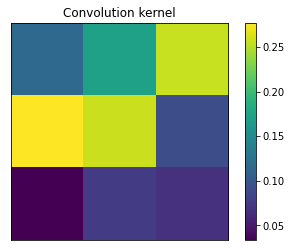

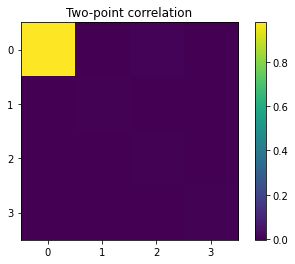

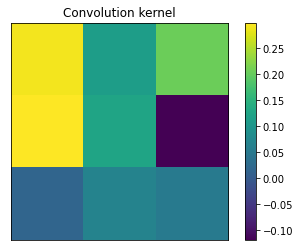

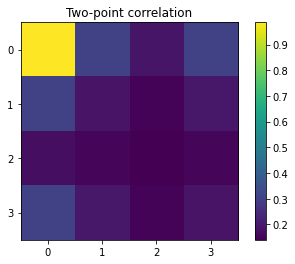

In [23]:
L = 4
M_SQ = (4 / L) ** 2
BATCH_SIZE = 4000
N_STEPS = 1000

kernel = torch.empty(3, 3).uniform_().div(3)
target = FreeTheoryTarget(M_SQ)
layers = [ConvLayer(kernel)]
model = Model(layers, target, BATCH_SIZE, L)
model.layers[0].visualise()

trainer = pl.Trainer(
    gpus=1,
    max_steps=N_STEPS,  # total number of training steps
    val_check_interval=10000,  # how often to run sampling
    limit_val_batches=1,  # one batch for each val step
    callbacks=[RichProgressBar()],
    enable_checkpointing=False,  # manually saving checkpoints
    num_sanity_val_steps=0,  # don't try to validate before training
)


trainer.fit(model)
_ = trainer.validate(model)

outputs = model.step_forward()
phi, log_prob = next(outputs)  # prior
convnet_phi4.plot.heatmap_correlator(phi)
for layer, (phi, log_prob) in zip(model.layers, outputs):
    layer.visualise()
    convnet_phi4.plot.heatmap_correlator(phi)

plt.show()

┏━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name   ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ layers │ ModuleList │     25 │
└───┴────────┴────────────┴────────┘

Trainable params: 25                                                                         
Non-trainable params: 0                                                                      
Total params: 25                                                                             
Total estimated model params size (MB): 0

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.9879988431930542     │
│            ess            │    0.9996282458305359     │
│            kl             │    -8.834809303283691     │
│           r_max           │            2.0            │
│            tau            │     0.512401282787323     │
└───────────────────────────┴───────────────────────────┘

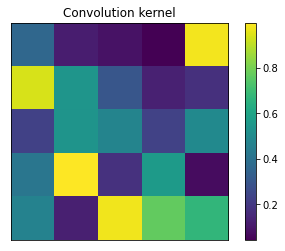

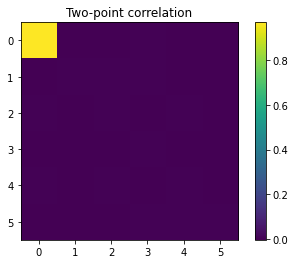

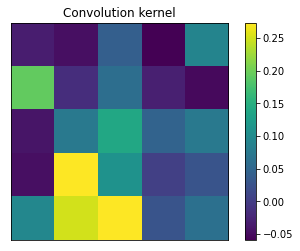

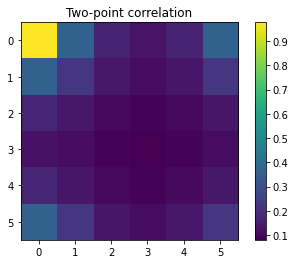

In [25]:
L = 6
M_SQ = (4 / L) ** 2
BATCH_SIZE = 4000
N_STEPS = 1000

kernel = torch.empty(5, 5).uniform_()
target = FreeTheoryTarget(M_SQ)
layers = [ConvLayer(kernel)]
model = Model(layers, target, BATCH_SIZE, L)
model.layers[0].visualise()

trainer = pl.Trainer(
    gpus=1,
    max_steps=N_STEPS,  # total number of training steps
    val_check_interval=10000,  # how often to run sampling
    limit_val_batches=1,  # one batch for each val step
    callbacks=[RichProgressBar()],
    enable_checkpointing=False,  # manually saving checkpoints
    num_sanity_val_steps=0,  # don't try to validate before training
)


trainer.fit(model)
_ = trainer.validate(model)

outputs = model.step_forward()
phi, log_prob = next(outputs)  # prior
convnet_phi4.plot.heatmap_correlator(phi)
for layer, (phi, log_prob) in zip(model.layers, outputs):
    layer.visualise()
    convnet_phi4.plot.heatmap_correlator(phi)

plt.show()

┏━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name   ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ layers │ ModuleList │    361 │
└───┴────────┴────────────┴────────┘

Trainable params: 361                                                                        
Non-trainable params: 0                                                                      
Total params: 361                                                                            
Total estimated model params size (MB): 0

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.9840984344482422     │
│            ess            │    0.9990106225013733     │
│            kl             │    -129.4799346923828     │
│           r_max           │            2.0            │
│            tau            │    0.5165017247200012     │
└───────────────────────────┴───────────────────────────┘

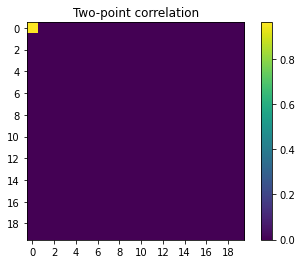

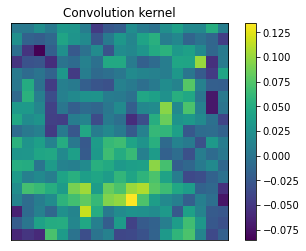

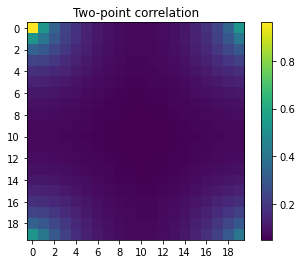

In [27]:
L = 20
M_SQ = (4 / L) ** 2
BATCH_SIZE = 4000
N_STEPS = 1000

kernel = torch.empty(19, 19).uniform_().div(10)
target = FreeTheoryTarget(M_SQ)
layers = [ConvLayer(kernel)]
model = Model(layers, target, BATCH_SIZE, L)

trainer = pl.Trainer(
    gpus=1,
    max_steps=N_STEPS,  # total number of training steps
    val_check_interval=10000,  # how often to run sampling
    limit_val_batches=1,  # one batch for each val step
    callbacks=[RichProgressBar()],
    enable_checkpointing=False,  # manually saving checkpoints
    num_sanity_val_steps=0,  # don't try to validate before training
)

trainer.fit(model)
_ = trainer.validate(model)

outputs = model.step_forward()
phi, log_prob = next(outputs)  # prior
convnet_phi4.plot.heatmap_correlator(phi)
for layer, (phi, log_prob) in zip(model.layers, outputs):
    layer.visualise()
    convnet_phi4.plot.heatmap_correlator(phi)

plt.show()

## Initialisation dependence

In [7]:
BATCH_SIZE = 4000
N_STEPS = 1000

import logging

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

results = []

for L in [4, 6, 8, 10, 12]:
    print(L)

    M_SQ = (4 / L) ** 2
    target = FreeTheoryTarget(M_SQ)

    for _ in range(20):
        trainer = pl.Trainer(
            gpus=1,
            max_steps=N_STEPS,
            val_check_interval=10000,
            limit_val_batches=1,
            enable_checkpointing=False,
            enable_progress_bar=False,
            num_sanity_val_steps=0,
            enable_model_summary=False,
        )
        kernel = torch.empty(L - 1, L - 1).uniform_()
        layers = [ConvLayer(kernel)]
        model = Model(layers, target, BATCH_SIZE, L)

        trainer.fit(model)
        (metrics,) = trainer.validate(model, verbose=False)
        metrics["L"] = L

        results.append(metrics)

4
6
8
10
12


array([[<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'6'}>],
       [<AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'10'}>],
       [<AxesSubplot:title={'center':'12'}>, <AxesSubplot:>]],
      dtype=object)

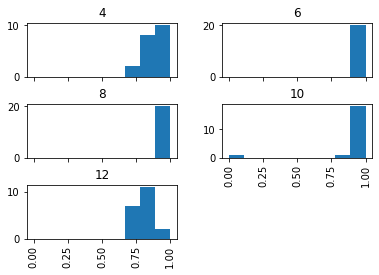

In [16]:
import numpy as np

df_list = []
for L, res in results.items():
    df = pd.DataFrame(res)
    df["L"] = L
    df_list.append(df)

df = pd.concat(df_list)
df.hist("acc", by="L", sharex=True, bins=np.linspace(0, 1, 10))

## Kernel size dependence

3


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │   0.0013001300394535065   │
│            ess            │  0.00015926157357171178   │
│            kl             │     -86.0988998413086     │
│           r_max           │          4621.0           │
│            tau            │    1684.4752197265625     │
└───────────────────────────┴───────────────────────────┘

5


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │   0.0028002799954265356   │
│            ess            │   0.0001966798008652404   │
│            kl             │    -102.8049087524414     │
│           r_max           │          2839.0           │
│            tau            │     947.3538208007812     │
└───────────────────────────┴───────────────────────────┘

7


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │   0.004100410267710686    │
│            ess            │  0.00038336258148774505   │
│            kl             │    -115.20179748535156    │
│           r_max           │          3429.0           │
│            tau            │     968.6862182617188     │
└───────────────────────────┴───────────────────────────┘

9


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │   0.002200220013037324    │
│            ess            │   0.0004426096857059747   │
│            kl             │    -116.44147491455078    │
│           r_max           │          5866.0           │
│            tau            │     2464.59716796875      │
└───────────────────────────┴───────────────────────────┘

11


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │   0.022302230820059776    │
│            ess            │   0.0009026500629261136   │
│            kl             │    -122.89921569824219    │
│           r_max           │          2159.0           │
│            tau            │    460.86895751953125     │
└───────────────────────────┴───────────────────────────┘

13


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.4406440556049347     │
│            ess            │     0.331617534160614     │
│            kl             │    -128.8888397216797     │
│           r_max           │           60.0            │
│            tau            │    3.1770846843719482     │
└───────────────────────────┴───────────────────────────┘

15


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.8103810548782349     │
│            ess            │    0.8964096903800964     │
│            kl             │    -129.40602111816406    │
│           r_max           │           10.0            │
│            tau            │    0.7645388245582581     │
└───────────────────────────┴───────────────────────────┘

17


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.9820982217788696     │
│            ess            │    0.9991326928138733     │
│            kl             │    -129.4796905517578     │
│           r_max           │            2.0            │
│            tau            │    0.5183018445968628     │
└───────────────────────────┴───────────────────────────┘

19


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.9793979525566101     │
│            ess            │    0.9987057447433472     │
│            kl             │    -129.4794158935547     │
│           r_max           │            2.0            │
│            tau            │    0.5216022729873657     │
└───────────────────────────┴───────────────────────────┘

<AxesSubplot:xlabel='K'>

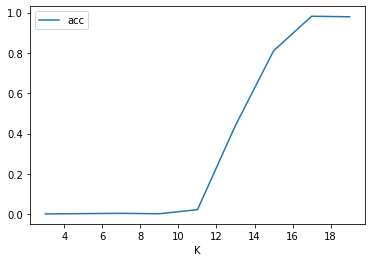

In [30]:
L = 20
M_SQ = (4 / L) ** 2
BATCH_SIZE = 4000
N_STEPS = 1000

target = FreeTheoryTarget(M_SQ)

results_k = []
for K in range(3, 20, 2):
    print(K)
    kernel = torch.empty(K, K).uniform_().div(10)

    layers = [ConvLayer(kernel)]
    model = Model(layers, target, BATCH_SIZE, L)

    trainer = pl.Trainer(
        gpus=1,
        max_steps=N_STEPS,  # total number of training steps
        val_check_interval=10000,  # how often to run sampling
        limit_val_batches=1,  # one batch for each val step
        enable_progress_bar=False,
        enable_checkpointing=False,  # manually saving checkpoints
        num_sanity_val_steps=0,  # don't try to validate before training
        enable_model_summary=False,
    )

    trainer.fit(model)
    (metrics,) = trainer.validate(model)
    metrics["K"] = K

    results_k.append(metrics)

df = pd.DataFrame(results_k)
df.plot(
    "K",
    "acc",
)

This is interesting. The correlation length is 5, but the acceptance remains very low until the kernel size hits around 11-13

┏━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name   ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ layers │ ModuleList │     25 │
└───┴────────┴────────────┴────────┘

Trainable params: 25                                                                         
Non-trainable params: 0                                                                      
Total params: 25                                                                             
Total estimated model params size (MB): 0

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │   0.0027002699207514524   │
│            ess            │   0.0003611703868955374   │
│            kl             │     -108.301025390625     │
│           r_max           │          5296.0           │
│            tau            │    2017.0904541015625     │
└───────────────────────────┴───────────────────────────┘

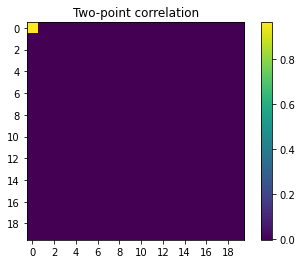

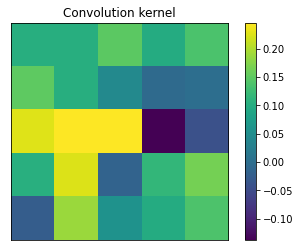

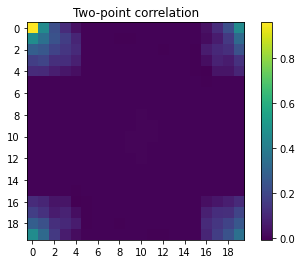

In [31]:
L = 20
M_SQ = (4 / L) ** 2
BATCH_SIZE = 4000
N_STEPS = 1000

kernel = torch.empty(5, 5).uniform_().div(10)
target = FreeTheoryTarget(M_SQ)
layers = [ConvLayer(kernel)]
model = Model(layers, target, BATCH_SIZE, L)

trainer = pl.Trainer(
    gpus=1,
    max_steps=N_STEPS,  # total number of training steps
    val_check_interval=10000,  # how often to run sampling
    limit_val_batches=1,  # one batch for each val step
    callbacks=[RichProgressBar()],
    enable_checkpointing=False,  # manually saving checkpoints
    num_sanity_val_steps=0,  # don't try to validate before training
)

trainer.fit(model)
_ = trainer.validate(model)

outputs = model.step_forward()
phi, log_prob = next(outputs)  # prior
convnet_phi4.plot.heatmap_correlator(phi)
for layer, (phi, log_prob) in zip(model.layers, outputs):
    layer.visualise()
    convnet_phi4.plot.heatmap_correlator(phi)

plt.show()

## Rotation equivariance

┏━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name   ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ layers │ ModuleList │     15 │
└───┴────────┴────────────┴────────┘

Trainable params: 15                                                                         
Non-trainable params: 0                                                                      
Total params: 15                                                                             
Total estimated model params size (MB): 0

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │   0.0014001399977132678   │
│            ess            │  0.00022003240883350372   │
│            kl             │    -96.05780029296875     │
│           r_max           │          5551.0           │
│            tau            │     2801.606689453125     │
└───────────────────────────┴───────────────────────────┘

┏━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name   ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ layers │ ModuleList │     25 │
└───┴────────┴────────────┴────────┘

Trainable params: 25                                                                         
Non-trainable params: 0                                                                      
Total params: 25                                                                             
Total estimated model params size (MB): 0

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.9964995980262756     │
│            ess            │    0.9999658465385437     │
│            kl             │    -8.835005760192871     │
│           r_max           │            1.0            │
│            tau            │    0.5035003423690796     │
└───────────────────────────┴───────────────────────────┘

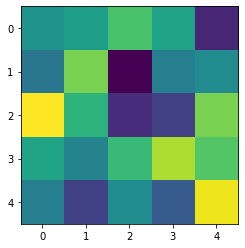

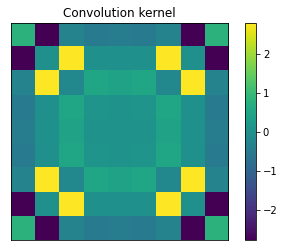

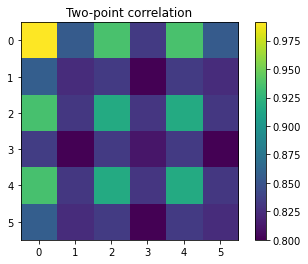

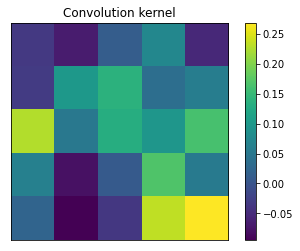

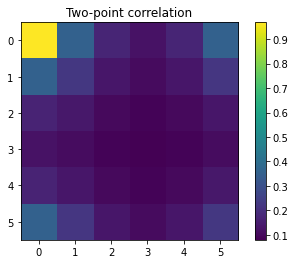

In [38]:
L = 6
M_SQ = (4 / L) ** 2
BATCH_SIZE = 4000
N_STEPS = 1000

kernel = torch.empty(5, 5).uniform_()
plt.imshow(kernel)

target = FreeTheoryTarget(M_SQ)

normal_layer = ConvLayer(kernel)
inv_layer = RotationInvariantConvLayer(kernel.tril())

for layer in reversed([normal_layer, inv_layer]):

    model = Model([layer], target, BATCH_SIZE, L)

    trainer = pl.Trainer(
        gpus=1,
        max_steps=N_STEPS,  # total number of training steps
        val_check_interval=10000,  # how often to run sampling
        limit_val_batches=1,  # one batch for each val step
        callbacks=[RichProgressBar()],
        enable_checkpointing=False,  # manually saving checkpoints
        num_sanity_val_steps=0,  # don't try to validate before training
    )

    trainer.fit(model)
    _ = trainer.validate(model)

    outputs = model.step_forward()
    phi, log_prob = next(outputs)  # prior
    model.layers[0].visualise()
    phi, log_prob = next(outputs)
    convnet_phi4.plot.heatmap_correlator(phi)

plt.show()

# Phi^4 Example

I don't expect this to do well without additional non-linearities.

In [40]:
class PhiFourTarget:
    def __init__(self, beta: float, lam: float):
        self.beta = beta
        self.lam = lam

    def action(self, phi: torch.Tensor):
        assert phi.dim() == 3

        action_density = torch.zeros_like(phi)
        action_density.sub_(phi.mul(phi.roll(-1, 1)).mul(self.beta))
        action_density.sub_(phi.mul(phi.roll(-1, 2)).mul(self.beta))
        action_density.add_(phi.pow(2).mul((1 - 2 * self.lam)))
        action_density.add_(phi.pow(4).mul(self.lam))

        return action_density.flatten(start_dim=1).sum(dim=1)

    def log_prob(self, phi: torch.Tensor):
        return self.action(phi).neg()

┏━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name   ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ layers │ ModuleList │     25 │
└───┴────────┴────────────┴────────┘

Trainable params: 25                                                                         
Non-trainable params: 0                                                                      
Total params: 25                                                                             
Total estimated model params size (MB): 0

Output()

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            acc            │    0.08390839397907257    │
│            ess            │   0.013945423997938633    │
│            kl             │    -27.308216094970703    │
│           r_max           │           840.0           │
│            tau            │     84.42241668701172     │
└───────────────────────────┴───────────────────────────┘

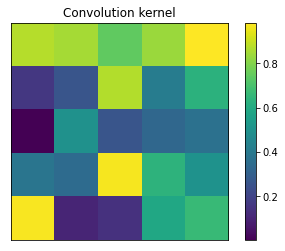

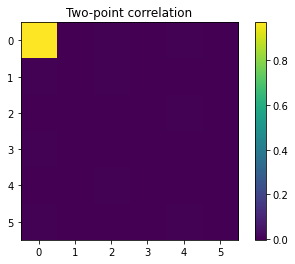

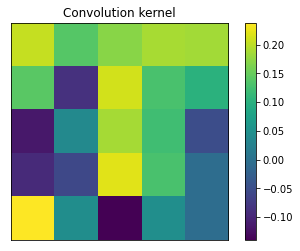

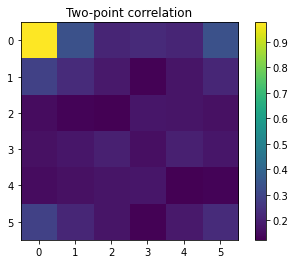

In [41]:
L = 6
BETA = 0.537
LAM = 0.5
BATCH_SIZE = 4000
N_STEPS = 1000

kernel = torch.empty(5, 5).uniform_().div(25)
target = PhiFourTarget(BETA, LAM)
layers = [ConvLayer(kernel)]
model = Model(layers, target, BATCH_SIZE, L)
model.layers[0].visualise()

trainer = pl.Trainer(
    gpus=1,
    max_steps=N_STEPS,  # total number of training steps
    val_check_interval=10000,  # how often to run sampling
    limit_val_batches=1,  # one batch for each val step
    callbacks=[RichProgressBar()],
    enable_checkpointing=False,  # manually saving checkpoints
    num_sanity_val_steps=0,  # don't try to validate before training
)


trainer.fit(model)
_ = trainer.validate(model)

outputs = model.step_forward()
phi, log_prob = next(outputs)  # prior
convnet_phi4.plot.heatmap_correlator(phi)
for layer, (phi, log_prob) in zip(model.layers, outputs):
    layer.visualise()
    convnet_phi4.plot.heatmap_correlator(phi)

plt.show()

1
2
3
4
5
6
7
8
9


<AxesSubplot:xlabel='n'>

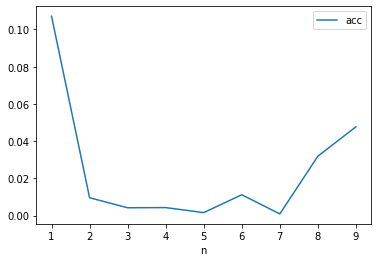

In [45]:
L = 6
BETA = 0.537
LAM = 0.5
BATCH_SIZE = 4000
N_STEPS = 1000

target = PhiFourTarget(BETA, LAM)

results_phi4 = []
for n in range(1, 10):
    print(n)

    trainer = pl.Trainer(
        gpus=1,
        max_steps=N_STEPS,
        val_check_interval=10000,
        limit_val_batches=1,
        enable_checkpointing=False,
        enable_progress_bar=False,
        num_sanity_val_steps=0,
        enable_model_summary=False,
    )
    kernel = torch.empty(5, 5).uniform_().div(n)
    layers = [ConvLayer(kernel) for _ in range(n)]
    model = Model(layers, target, BATCH_SIZE, L)

    trainer.fit(model)
    (metrics,) = trainer.validate(model, verbose=False)
    metrics["n"] = n

    results_phi4.append(metrics)

df = pd.DataFrame(results_phi4)
df.plot(
    "n",
    "acc",
)